In [53]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import contextily as cx


# Read the letters
letters = pd.read_csv('../data/letters.csv')
# group by place and location
places = letters.groupby(['place', 'location']).size().reset_index(name='count')
letters = letters.drop(columns=['location'])
places['place_id'] = places.index + 1
places = places.drop(columns=['count'])

cols = places.columns.tolist()
cols = cols[-1:] + cols[:-1]
places = places[cols]

In [54]:
# parse into geopandas
places["geometry"] = places["location"].str.split(",")

places['geometry'] = places['geometry'].apply(lambda x: x[:-1])

# convert geometry to wkt from [lat,lon] to POINT(lon lat)
places['geometry'] = places['geometry'].apply(lambda x: 'POINT (' + x[1] + ' ' + x[0] + ')')
# geometry to geometry object

places['geometry'] = places['geometry'].apply(wkt.loads)

# convert to geodataframe
gplaces = gpd.GeoDataFrame(places, geometry='geometry')

# remove location col
gplaces = gplaces.drop(columns=['location'])

# rename place to name



In [55]:
gplaces

,place_id,place,geometry
0,1,Angerborg (Węgorzewo),POINT (21.74163 54.21359)
1,2,Arys (Orzysz),POINT (21.94730 53.80989)
2,3,Arys (Orzysz),POINT (21.94730 53.80989)
3,4,Augostov (Augustów),POINT (22.97960 53.84344)
4,5,"Bakkely, Regstrup, Fyn",POINT (10.76257 55.35196)
...,...,...,...
70,71,Vauxtin,POINT (3.60215 49.35020)
71,72,Villeselve,POINT (3.10962 49.69007)
72,73,Vivaise,POINT (3.55993 49.61988)
73,74,Willenberg (Wielbark),POINT (20.94576 53.39815)


In [56]:
# merge places into letters
placed_letters = letters.merge(gplaces[['place','place_id']], on='place',how='left',)
placed_letters.place_id = placed_letters.place_id.fillna(0).astype(int)
placed_letters = placed_letters.drop(columns=['place'])
#placed_letters.value_counts('place_id')

gplaces = gplaces.rename(columns={'place': 'name'})

# save to file
gplaces.to_csv('../data/places.csv', index=False)

# write to csv
placed_letters.to_csv('../data/placed_letters.csv', index=False)


## clean up steps

In [48]:
import requests

def get_lat_lon(p):
    point = p.centroid
    return point.y, point.x


# Add OSM and Google Maps links
gplaces['lat_lon'] = gplaces['geometry'].apply(get_lat_lon)
gplaces['osm_link'] = gplaces['lat_lon'].apply(lambda x: f"https://www.openstreetmap.org/?mlat={x[0]}&mlon={x[1]}&zoom=12")
gplaces['google_maps_link'] = gplaces['lat_lon'].apply(lambda x: f"https://www.google.com/maps/?q={x[0]},{x[1]}")

def reverse_geocode(lat_lon):
    base_url = "https://nominatim.openstreetmap.org/reverse"
    params = {
        'format': 'jsonv2',
        'lat': lat_lon[0],
        'lon': lat_lon[1]
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data.get('address', {}).get('city', 'Unknown')
    else:
        return 'Error'

# Add closest city name
gplaces['closest_city'] = gplaces['lat_lon'].apply(reverse_geocode)

# Drop the lat_lon column if it's not needed
gplaces.drop(columns=['lat_lon'], inplace=True)

# Save to CSV
gplaces.to_csv('../data/places_cleanup.csv', index=False)

In [39]:
gplaces

,place_id,name,geometry,lat_lon,osm_link,google_maps_link
0,1,"Villeselve,",POINT (3.10962 49.69007),"(3.1096159, 49.6900681)",https://www.openstreetmap.org/?mlat=3.1096159&...,"https://www.google.com/maps/?q=3.1096159,49.69..."
1,2,Angerborg (W?gorzewo),POINT (21.74163 54.21359),"(21.7416301, 54.21359)",https://www.openstreetmap.org/?mlat=21.7416301...,"https://www.google.com/maps/?q=21.7416301,54.2..."
2,3,"Arys (Gmina Orzysz, Poland)",POINT (21.94730 53.80989),"(21.9473, 53.80989)",https://www.openstreetmap.org/?mlat=21.9473&ml...,"https://www.google.com/maps/?q=21.9473,53.80989"
3,4,Arys (Orzysz),POINT (21.94730 53.80989),"(21.9473, 53.80989)",https://www.openstreetmap.org/?mlat=21.9473&ml...,"https://www.google.com/maps/?q=21.9473,53.80989"
4,5,Augostowo (Augustow),POINT (22.97960 53.84344),"(22.9796023, 53.8434431)",https://www.openstreetmap.org/?mlat=22.9796023...,"https://www.google.com/maps/?q=22.9796023,53.8..."
...,...,...,...,...,...,...
70,71,Vivaise,POINT (3.55993 49.61988),"(3.5599266, 49.6198789)",https://www.openstreetmap.org/?mlat=3.5599266&...,"https://www.google.com/maps/?q=3.5599266,49.61..."
71,72,Willenberg = Wielbark,POINT (20.94576 53.39815),"(20.9457569, 53.3981483)",https://www.openstreetmap.org/?mlat=20.9457569...,"https://www.google.com/maps/?q=20.9457569,53.3..."
72,73,isenheim,POINT (7.25027 47.90383),"(7.2502722, 47.9038256)",https://www.openstreetmap.org/?mlat=7.2502722&...,"https://www.google.com/maps/?q=7.2502722,47.90..."
73,74,rehsau,POINT (21.58484 54.23244),"(21.5848402, 54.2324355)",https://www.openstreetmap.org/?mlat=21.5848402...,"https://www.google.com/maps/?q=21.5848402,54.2..."


In [27]:
gdf1914world = gpd.read_file('../maps/1914/1914.geojson')
# remove the world outside 
ylim=(43,60)
xlim=(-3,40)

# remove countries outside the map
gdf1914 = gdf1914world.cx[xlim[0]:xlim[1], ylim[0]:ylim[1]]


<Axes: >

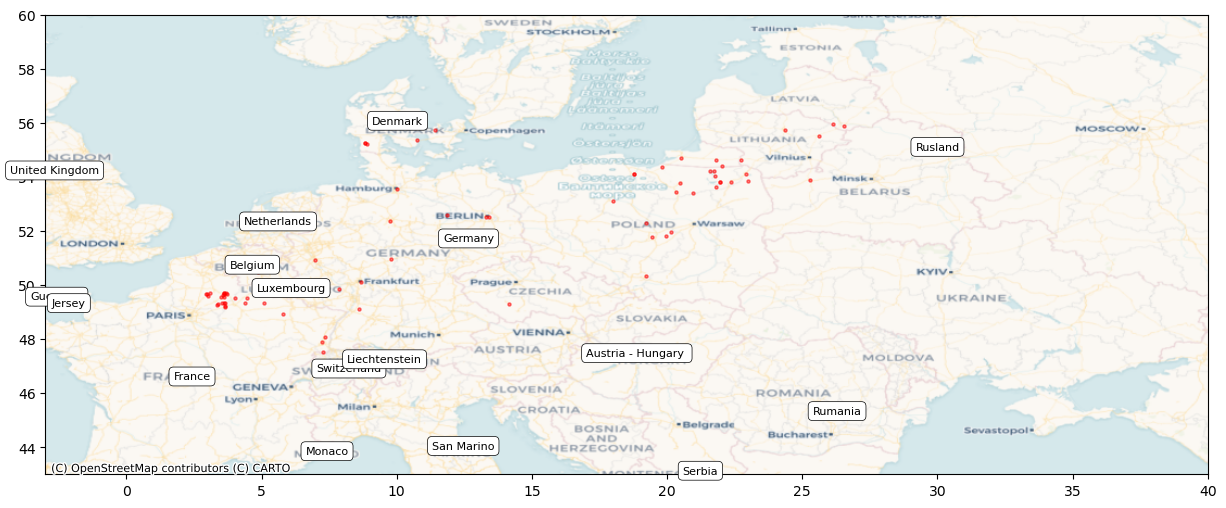

In [29]:
fig, ax = plt.subplots(figsize=(15, 15))



ax.set_ylim(43, 60)
ax.set_xlim(-3, 40)
#gdf1914.plot(ax=ax, cmap="tab20c", edgecolor="black", alpha=0.5)
gdf1914.apply(
    lambda x: ax.annotate(
        x.NAME,
        xy=x.geometry.centroid.coords[0],
        ha="center",
        size=8,
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=0.5),
    ),
    axis=1,
)
ax.annotate(
    "Rusland",
    xy=(30, 55),
    ha="center",
    size=8,
    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=0.5),
)

cx.add_basemap(ax, crs="epsg:4326", source=cx.providers.CartoDB.Voyager)
gplaces.plot(ax=ax, edgecolor="red", markersize=5, alpha=0.5, color="red")